# More node interpolation

In [1]:
import mne
import numpy as np
import pandas as pd
import scipy.io
from scipy.interpolate import NearestNDInterpolator

In [2]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

plotly.offline.init_notebook_mode(connected=True)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

## Read in data

In [3]:
raw = mne.io.read_raw_eeglab("../927/fixica.set")

Reading C:\Users\Yiki\Documents\UBC\MDS\Homework\capstone\927\fixica.fdt


<ipython-input-3-b61a7178949b>:1: RuntimeWarning:

Data file name in EEG.data (927 fix ica correct.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).



In [12]:
ten_five_montage = mne.channels.make_standard_montage("standard_1005")

In [13]:
standard_coord = []
for key, value in ten_five_montage.get_positions()["ch_pos"].items():
    standard_coord.append(value.tolist())
standard_coord = np.array(standard_coord)

In [14]:
# get the coordinate for each nodes and save them in an array
node_list = []
for channel in raw.get_montage().ch_names:
    node_list.append(ten_five_montage.get_positions()["ch_pos"][channel].tolist())
node_coord = np.array(node_list)

In [22]:
x=np.array(standard_coord)[:, 0]
y=np.array(standard_coord)[:, 1]
z=np.array(standard_coord)[:, 2]

In [15]:
df = raw.to_data_frame()

In [19]:
eeg = df[df['time'] == 0].iloc[:, 1:].mean().values

In [20]:
inter = NearestNDInterpolator(node_coord, eeg)

In [23]:
figu = go.Figure(data=[
    go.Mesh3d(
        x=np.array(standard_coord)[:, 0],
        y=np.array(standard_coord)[:, 1],
        z=np.array(standard_coord)[:, 2],
        intensity=inter(np.array(list(zip(x, y, z)))),
        intensitymode = 'vertex',
        alphahull=1,
        opacity=1,
    )
])

figu.show()

## Animated

In [16]:
nb_frames = df["time"].head(50)

In [17]:
def interpolated_time(x, y, z, k):
    now = df[df["time"] == k]
    eeg = now.iloc[:, 1:].mean().values
    interpolate_model = NearestNDInterpolator(node_coord, eeg)
    return interpolate_model(np.array(list(zip(x, y, z))))

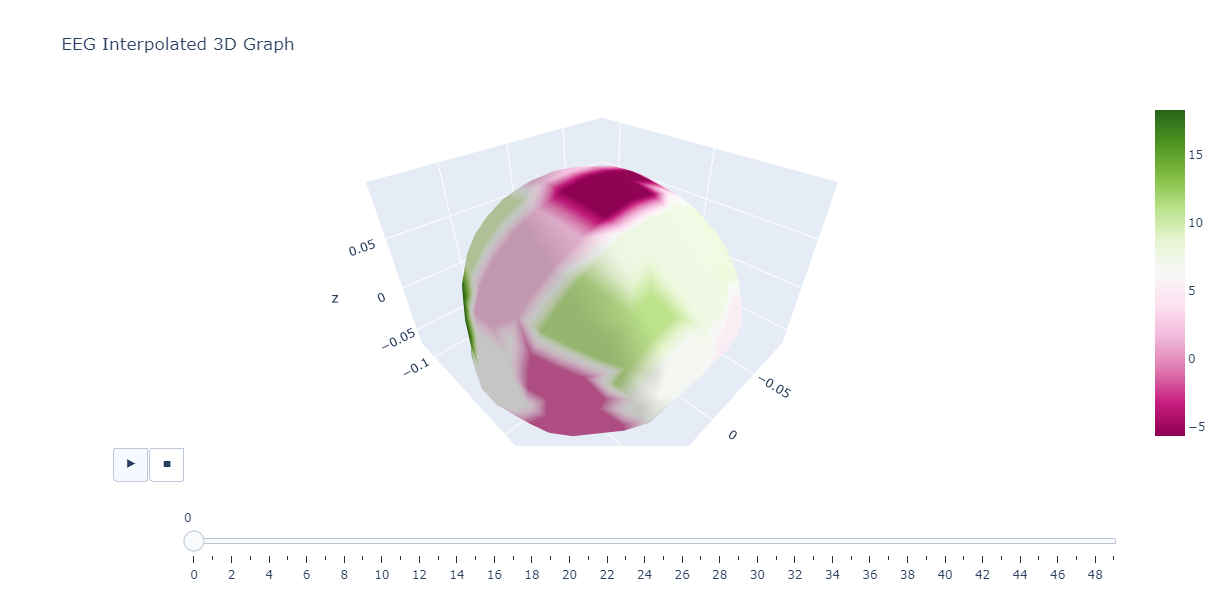

In [24]:
fig = go.Figure(
    frames=[
        go.Frame(
            data=go.Mesh3d(
                x=np.array(standard_coord)[:, 0],
                y=np.array(standard_coord)[:, 1],
                z=np.array(standard_coord)[:, 2],
                intensity=interpolated_time(x, y, z, k),
                intensitymode="vertex",
                alphahull=1,
                opacity=1,
            ),
            name=str(
                k
            ),  # you need to name the frame for the animation to behave properly
        )
        for k in nb_frames
    ]
)

# Add data to be displayed before animation starts
fig.add_trace(
    go.Mesh3d(
                x=np.array(standard_coord)[:, 0],
                y=np.array(standard_coord)[:, 1],
                z=np.array(standard_coord)[:, 2],
                intensity=interpolated_time(x, y, z, 0),
                intensitymode="vertex",
                alphahull=1,
                opacity=1,
            )
)
# fig.add_scatter3d(
#     connectgaps=True,
#     x=node_df["x"],
#     y=node_df["y"],
#     z=node_df["z"],
#     text=node_df["channel"],
#     mode="markers",
# )


def frame_args(duration):
    return {
        "frame": {"duration": duration},
        "mode": "immediate",
        "fromcurrent": True,
        "transition": {"duration": duration, "easing": "linear"},
    }


sliders = [
    {
        "pad": {"b": 10, "t": 60},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": [
            {
                "args": [[f.name], frame_args(0)],
                "label": str(k),
                "method": "animate",
            }
            for k, f in enumerate(fig.frames)
        ],
    }
]

fig.update_layout(
    title="EEG Interpolated 3D Graph",
    width=1000,
    height=600,
    scene=dict(
        zaxis=dict(
            range=[
                np.nan_to_num(np.array(standard_coord)[:, 2].tolist()).min(),
                np.nan_to_num(np.array(standard_coord)[:, 2].tolist()).max(),
            ],
            autorange=False,
        ),
        aspectratio=dict(x=1.5, y=1.5, z=1),
    ),
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [None, frame_args(50)],
                    "label": "&#9654;",  # play symbol
                    "method": "animate",
                },
                {
                    "args": [[None], frame_args(0)],
                    "label": "&#9724;",  # pause symbol
                    "method": "animate",
                },
            ],
            "direction": "left",
            "pad": {"r": 1, "t": 1},
            "type": "buttons",
            "x": 0.1,
            "y": 0,
        }
    ],
    sliders=sliders,
)

## Try to get the surface plot

In [ ]:
fig = px.scatter_3d(
    x=np.array(node_coord)[:, 0],
    y=np.array(node_coord)[:, 1],
    z=np.array(node_coord)[:, 2],
    color=eeg,
    color_continuous_scale="RdYlGn_r",
)

fig.add_mesh3d(
    x=np.array(standard_coord)[:, 0],
    y=np.array(standard_coord)[:, 1],
    z=np.array(standard_coord)[:, 2],
#     intensity=eeg,
    alphahull=1,
    opacity=0.4,
)

fig.show()

In [ ]:
## matplotlib to get the surface, but not sure how to change color
# color_dimension = np.reshape(
#         interpolated_eeg, (-1, 343)
#     ) # change to desired fourth dimension
# minn, maxx = color_dimension.min(), color_dimension.max()
# norm = matplotlib.colors.Normalize(minn, maxx)
# m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
# m.set_array([])
# fcolors = m.to_rgba(color_dimension)

fig_mat = plt.figure()
ax = fig_mat.add_subplot(111, projection="3d")
ax.plot_trisurf(
    np.array(standard_coord)[:, 0],
    np.array(standard_coord)[:, 1],
    np.array(standard_coord)[:, 2],
    facecolors=cm.Oranges(interpolated_eeg),
#     alpha=0.5,
)
plt.show()

In [ ]:
fig_vol = go.Figure(data=go.Surface(
    x=X,
    y=Y,
    z=Z,
    surfacecolor=np.outer(np.outer(interpolated_eeg.T, interpolated_eeg).T, interpolated_eeg),
#     isomin=0.1,
#     isomax=0.8,
#     opacity=0.1, # needs to be small to see through all surfaces
#     surface_count=17, # needs to be a large number for good volume rendering
    ))
fig_vol.show()

### 3D animated scatter plot using plotly

In [ ]:
plot_df = raw.to_data_frame()
col_names = plot_df.columns.tolist()[1:]
df = plot_df.melt(
    id_vars="time", value_vars=col_names, var_name="channels", value_name="signal"
)
channel_dict = ten_five_montage.get_positions()["ch_pos"]
plot_df3 = df[df["time"] <= 50]

In [ ]:
plot_df4 = plot_df3.copy()
loca_listx = []
loca_listy = []
loca_listz = []
for index, row in plot_df4.iterrows():
    loca_listx.append(channel_dict[row["channels"]][0])
    loca_listy.append(channel_dict[row["channels"]][1])
    loca_listz.append(channel_dict[row["channels"]][2])
plot_df4["chan_locax"] = loca_listx
plot_df4["chan_locay"] = loca_listy
plot_df4["chan_locaz"] = loca_listz

In [ ]:
fig_scatter = px.scatter_3d(
    plot_df4,
    x="chan_locax",
    y="chan_locay",
    z="chan_locaz",
    color="signal",
    animation_frame="time",
    hover_name="channels",
    text="channels",
    color_continuous_scale="RdYlGn_r",
)

fig_scatter.add_mesh3d(
    x=np.array(standard_coord)[:, 0],
    y=np.array(standard_coord)[:, 1],
    z=np.array(standard_coord)[:, 2],
    alphahull=1,
    opacity=0.4,
    color="cyan"
)

fig_scatter.show()

In [ ]:
import scipy.ndimage

sigma = [6, 6]
zSmooth = scipy.ndimage.filters.gaussian_filter(Z, sigma)